# **MALWARE DETECTION USING DT | SVM | GNN**

## **CONTENTS**

* Exploratory Data Analysis
* Algorithms Used:
    * Support Vector Machine
        * Linear Kernel
        * Polynomial Kernel
        * Radial Bias Function Kernel
    * K - Nearest Neighbor
* Visualising all the accuracies in the bar-graph

## **UPLOADING LIBRARIES**

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, recall_score, roc_curve, precision_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.exceptions import ConvergenceWarning


In [3]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## **EXPLORATORY DATA ANALYSIS**

In [4]:
# Set random seeds for reproducibility
np.random.seed(0)
import tensorflow as tf
tf.compat.v1.set_random_seed(0)

In [5]:
# Load the dataset
print("Loading data...")
data = pd.read_csv("../input/android-malware-dataset-for-machine-learning/drebin-215-dataset-5560malware-9476-benign.csv", 
                  encoding="utf-8", low_memory=False)
print(len(data.columns.tolist()))

Loading data...
216


In [6]:
# Check for missing values
print("Total missing values before cleaning:", sum(list(data.isna().sum())))

Total missing values before cleaning: 0


In [7]:
# Display initial data information
print("Initial data shape:", data.shape)
print("Initial data head:")
print(data.head())

Initial data shape: (15036, 216)
Initial data head:
   transact  onServiceConnected  bindService  attachInterface  \
0         0                   0            0                0   
1         0                   0            0                0   
2         0                   0            0                0   
3         0                   0            0                0   
4         0                   0            0                0   

   ServiceConnection  android.os.Binder  SEND_SMS  \
0                  0                  0         1   
1                  0                  0         1   
2                  0                  0         1   
3                  0                  0         0   
4                  0                  0         0   

   Ljava.lang.Class.getCanonicalName  Ljava.lang.Class.getMethods  \
0                                  0                            0   
1                                  0                            0   
2                              

In [8]:

# Map class labels to numeric values (B: Benign = 0, S: Malware = 1)
print("Converting class labels...")
data["class"] = data["class"].map({"B": 0, "S": 1})

Converting class labels...


In [9]:
# Handle missing values and special characters
print("Handling missing values and special characters...")
data = data.replace('[?,S]', np.NaN, regex=True)
print("Total missing values after replacing special chars:", sum(list(data.isna().sum())))
data.dropna(inplace=True)


Handling missing values and special characters...
Total missing values after replacing special chars: 5


In [10]:
# Convert all columns to numeric
print("Converting columns to numeric...")
for c in data.columns:
    data[c] = pd.to_numeric(data[c], errors='coerce')

Converting columns to numeric...


In [11]:
# Drop any newly created NaN values
data.dropna(inplace=True)
print("Final data shape after cleaning:", data.shape)

Final data shape after cleaning: (15031, 216)


In [12]:
# Display class distribution
print("Analyzing class distribution...")
classes, count = np.unique(data['class'], return_counts=True)
print("Class counts:", dict(zip(classes, count)))

Analyzing class distribution...
Class counts: {0: 9476, 1: 5555}


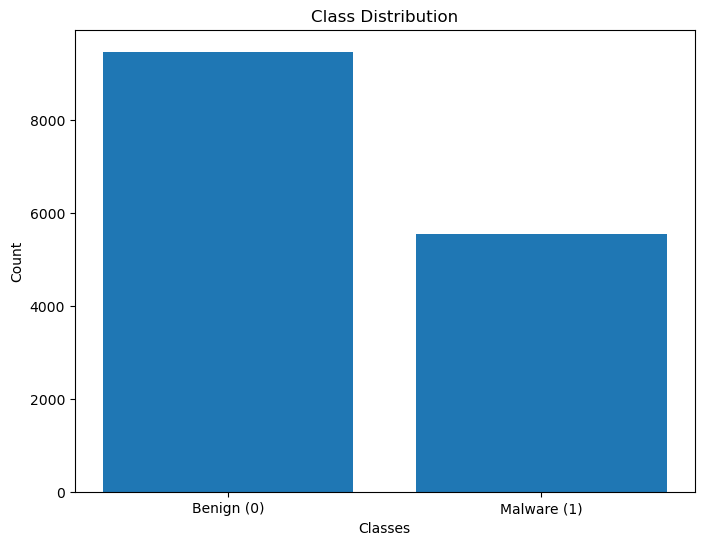

In [13]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(['Benign (0)', 'Malware (1)'], count)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [14]:

# Check for class imbalance and apply oversampling if necessary
X = data.drop("class", axis=1)
y = data["class"]

In [15]:
# Split the data into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting data into training and testing sets...


In [16]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution before oversampling:", np.bincount(y_train))

Training set shape: (12024, 215)
Testing set shape: (3007, 215)
Class distribution before oversampling: [7590 4434]


In [17]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Check original counts
print("Before:", Counter(y_train))

# Desired ratio: positives:negatives = 60:40
neg_count = sum(y_train == 0)
pos_target = int(neg_count * (60/40))  # make positives 1.5x negatives

ros = RandomOverSampler(
    sampling_strategy={0: neg_count, 1: pos_target},
    random_state=42
)

X_train, y_train = ros.fit_resample(X_train, y_train)

print("After:", Counter(y_train))


Before: Counter({0: 7590, 1: 4434})
After: Counter({1: 11385, 0: 7590})


In [18]:
print("Training set shape after oversampling:", X_train.shape)
print("Class distribution after oversampling:", np.bincount(y_train))

Training set shape after oversampling: (18975, 215)
Class distribution after oversampling: [ 7590 11385]


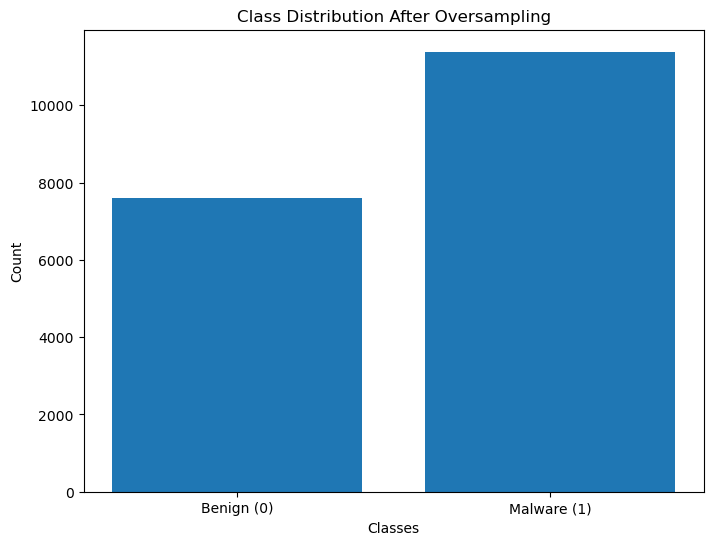

In [19]:
# Visualize balanced class distribution
plt.figure(figsize=(8, 6))
balanced_count = np.bincount(y_train)
plt.bar(['Benign (0)', 'Malware (1)'], balanced_count)
plt.title("Class Distribution After Oversampling")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


Generating correlation heatmap...


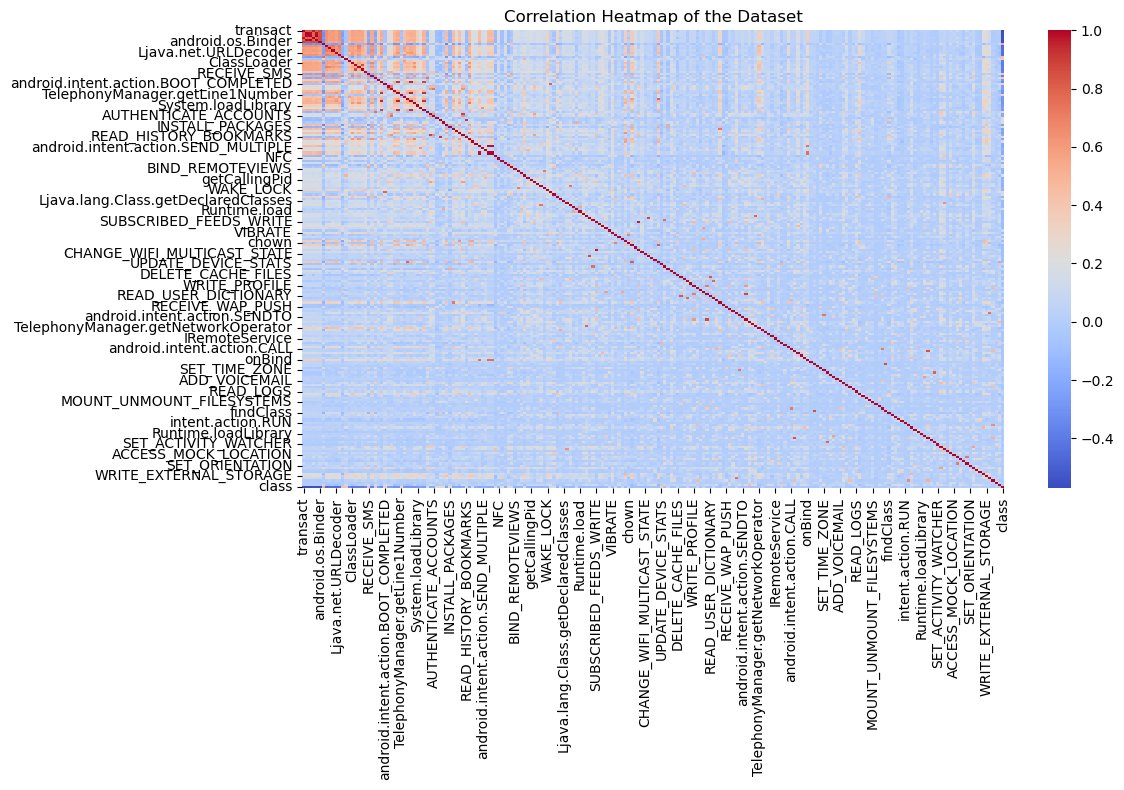

In [20]:
# Create correlation heatmap for feature analysis
print("Generating correlation heatmap...")
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of the Dataset")
plt.tight_layout()
plt.show()

## **SUPPORT VECTOR MACHINE**

Using three different kinds of Kernel in the SVM:<br>
* Linear Kernel
* Polynomial Kernel
* Radial Bias Function Kernel (RBF)

In [21]:
# Train SVM models with different kernels
print("\nTraining SVM models with different kernels...")
kernel_list = ['linear', 'poly', 'rbf']
svm_results = {}

for kernel in kernel_list:
    print(f"Training SVM with {kernel} kernel...")
    clf = SVC(kernel=kernel, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    svm_results[kernel] = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    print(f"SVM with {kernel} kernel results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")


Training SVM models with different kernels...
Training SVM with linear kernel...
SVM with linear kernel results:
  Accuracy: 0.9757
  F1 Score: 0.9679
  Precision: 0.9541
  Recall: 0.9822
Training SVM with poly kernel...
SVM with poly kernel results:
  Accuracy: 0.9707
  F1 Score: 0.9598
  Precision: 0.9841
  Recall: 0.9367
Training SVM with rbf kernel...
SVM with rbf kernel results:
  Accuracy: 0.9847
  F1 Score: 0.9795
  Precision: 0.9786
  Recall: 0.9804


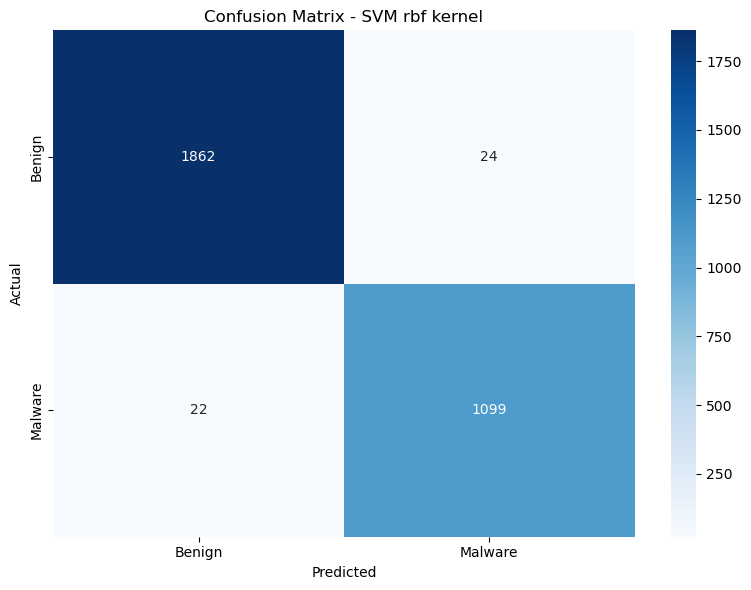

In [22]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malware'], 
            yticklabels=['Benign', 'Malware'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - SVM {kernel} kernel')
plt.tight_layout()
plt.show()

In [23]:
 # Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      1886
     Malware       0.98      0.98      0.98      1121

    accuracy                           0.98      3007
   macro avg       0.98      0.98      0.98      3007
weighted avg       0.98      0.98      0.98      3007



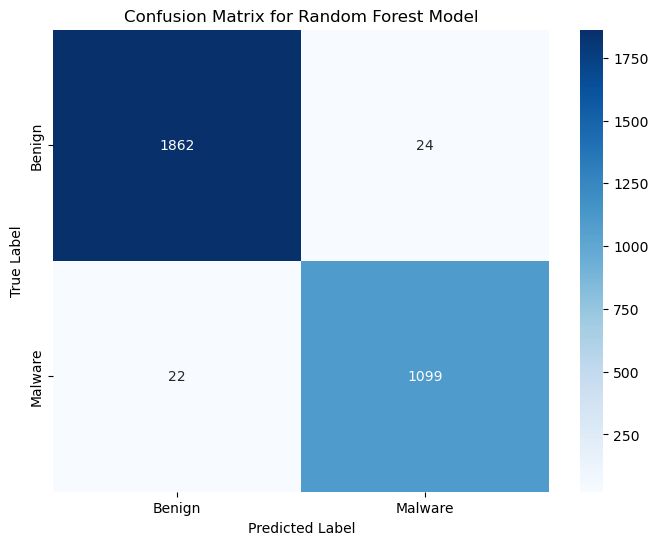

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure y_test (true labels) and y_pred (model's predictions) are available
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True,      # This writes the numbers in the squares
            fmt='d',         # Formats the numbers as integers
            cmap='Blues',    # Sets the color scheme
            xticklabels=['Benign', 'Malware'], 
            yticklabels=['Benign', 'Malware'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [25]:
# This gets the exact feature order your model was trained on
original_column_order = list(X_train.columns)
print("Successfully captured the original column order.")

Successfully captured the original column order.


In [26]:
# === 1. Imports ===
import numpy as np
import joblib
import json
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# ===========================================
# === 2. Prepare your data (replace later) ===
# ===========================================
# Example: You should already have `features` and `labels`
# X = features
# y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# =====================================
# === 3. Handle Class Imbalance ===
# =====================================
def compute_class_ratio(y):
    """Compute ratio of negative/positive samples for scale_pos_weight."""
    counts = np.bincount(y)
    if len(counts) > 1 and counts[1] > 0:
        return counts[0] / counts[1]
    return 1.0

ratio = compute_class_ratio(y_train)
print(f"✅ Using class weight (scale_pos_weight): {ratio:.2f}")

# =====================================
# === 4. Define More Powerful Model ===
# =====================================
xgb_model = XGBClassifier(
    n_estimators=2000,         # More boosting rounds
    max_depth=10,              # Deeper trees for complex patterns
    learning_rate=0.03,        # Lower LR + more rounds = smoother fit
    subsample=0.85,            # Fraction of training samples per tree
    colsample_bytree=0.85,     # Fraction of features per tree
    min_child_weight=2,        # Controls leaf purity
    gamma=1,                   # Min loss reduction for split
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=2.0,            # L2 regularization
    scale_pos_weight=ratio,    # Balance positives vs negatives
    booster='gbtree',          # Try "dart" if you want dropout boosting
    use_label_encoder=False,
    eval_metric='aucpr',       # Better for imbalanced data
    random_state=42,
    n_jobs=-1
)

# =====================================
# === 5. Train the Model ===
# =====================================
print("\n🚀 Training the XGBoost model with early stopping...")
xgb_model.fit(
    X_train,
    y_train,
    early_stopping_rounds=100,   # Allow longer patience
    eval_set=[(X_test, y_test)],
    verbose=100
)
print("👍 Training complete.")

# =====================================
# === 6. Evaluate Performance ===
# =====================================
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 XGBoost Model Results:")
for k, v in metrics.items():
    print(f"  {k.capitalize()}: {v:.4f}")

# =====================================
# === 7. Save Model + Metadata ===
# =====================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"xgb_model_{timestamp}.pkl"
joblib.dump(xgb_model, model_path)

metadata = {
    "timestamp": timestamp,
    "params": {
        "n_estimators": 2000,
        "max_depth": 10,
        "learning_rate": 0.03,
        "subsample": 0.85,
        "colsample_bytree": 0.85,
        "min_child_weight": 2,
        "gamma": 1,
        "reg_alpha": 0.1,
        "reg_lambda": 2.0,
        "scale_pos_weight": ratio
    },
    "metrics": metrics,
    "features_count": X_train.shape[1]
}
with open(f"model_metadata_{timestamp}.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n💾 Model saved to: {model_path}")
print(f"💾 Metadata saved to: model_metadata_{timestamp}.json")


✅ Using class weight (scale_pos_weight): 0.67

🚀 Training the XGBoost model with early stopping...
[0]	validation_0-aucpr:0.97102
[100]	validation_0-aucpr:0.99489
[200]	validation_0-aucpr:0.99698
[300]	validation_0-aucpr:0.99762
[400]	validation_0-aucpr:0.99793
[500]	validation_0-aucpr:0.99802
[600]	validation_0-aucpr:0.99809
[700]	validation_0-aucpr:0.99810
[775]	validation_0-aucpr:0.99813
👍 Training complete.

📊 XGBoost Model Results:
  Accuracy: 0.9870
  F1_score: 0.9825
  Precision: 0.9865
  Recall: 0.9786
  Roc_auc: 0.9988

💾 Model saved to: xgb_model_20250910_150109.pkl
💾 Metadata saved to: model_metadata_20250910_150109.json


Model Evaluation on Test Set
Accuracy   : 0.9870
Precision  : 0.9865
Recall     : 0.9786 (Sensitivity)
F1 Score   : 0.9825


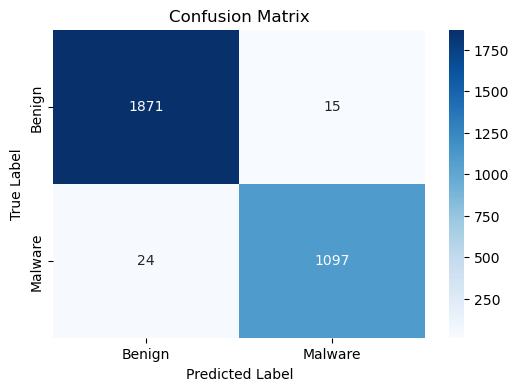

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)   # recall == sensitivity for positive class
f1 = f1_score(y_test, y_pred)

print("Model Evaluation on Test Set")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f} (Sensitivity)")
print(f"F1 Score   : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malware"],
            yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
